In [1]:
# Importing the os module to access environment variables
import os

# Setting an environment variable to allow multiple instances of OpenMP libraries to be loaded
# This is a workaround for certain macOS environments where OpenMP might cause conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [47]:
# !pip install thop mlflow optuna captum onnx onnx_tf

In [63]:
# Importing necessary libraries
import time       # for time-related functions
import math       # for mathematical functions
import datetime   # for datetime operations
from collections import OrderedDict  # for ordered dictionaries
from tqdm.auto import tqdm   # for progress bars
from pathlib import Path     # for working with file paths
from thop import profile# for calculating model FLOPs
from copy import deepcopy

# Importing PyTorch libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets.cifar import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import torch.nn.init as init   # for weight initialization

# Importing MLflow for experiment tracking
import mlflow

# Importing other utility libraries
import random     # for random number generation
import numpy as np   # for numerical operations
import psutil     # for system resource monitoring
import subprocess   # for executing shell commands
from torchsummary import summary   # for model summary
import matplotlib.pyplot as plt   # for plotting
import seaborn as sns   # for advanced plotting
from sklearn.metrics import confusion_matrix, classification_report   # for evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score   # for evaluation metrics

# Importing Captum for model interpretability
from captum.attr import FeatureAblation
from captum.attr import Occlusion
from captum.attr import LayerConductance
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# torch.cuda.memory._record_memory_history()

In [5]:
def increment_path(path, exist_ok=False, sep='', mkdir=True):
    # Convert the path to a Path object
    path = Path(path)

    # If the path already exists and `exist_ok` is False, handle incrementing the path
    if path.exists() and not exist_ok:
        # Check if the path is a file or a directory
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')
        # Loop over numbers starting from 2 to 9999 to find a unique name
        for n in range(2, 9999):
            # Construct the new path with the incremented number
            p = f'{path}{sep}{n}{suffix}'
            # Check if the constructed path exists, if not, break the loop
            if not os.path.exists(p):
                break
        # Update the path to the incremented path
        path = Path(p)

    # If `mkdir` is True, create the directory structure specified by the path
    if mkdir:
        path.mkdir(parents=True, exist_ok=True)

    # Return the incremented path
    return path

In [6]:
# Define the experiment name
EXPERIMENT_NAME = "exp"

# Get the current working directory and resolve its absolute path
FILE = Path(os.getcwd()).resolve()

# Create a save directory path by incrementing the path
SAVE_DIR = increment_path(FILE / "artifacts" / f"{EXPERIMENT_NAME}", exist_ok=False)

# Create a 'checkpoints' directory inside the save directory
(SAVE_DIR / 'checkpoints').mkdir(parents=True, exist_ok=True)

In [7]:
# Define the URI for local tracking using SQLite
local_tracking_uri = f"sqlite:///mlflow/mlflow.db"

# Set the tracking URI to the local URI
mlflow.set_tracking_uri(local_tracking_uri)

# Set the experiment name to the stem (last part) of the save directory path
mlflow.set_experiment(SAVE_DIR.stem)

2024/03/17 20:08:24 INFO mlflow.tracking.fluent: Experiment with name 'exp2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/content/mlruns/2', creation_time=1710706104057, experiment_id='2', last_update_time=1710706104057, lifecycle_stage='active', name='exp2', tags={}>

In [8]:
def set_experiment_seed(seed=42):
    """
    Set random seeds and CUDA-related flags for experiment reproducibility.
    """
    # Set random seeds for Python, NumPy, and random module
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If GPU is available, set random seed for CUDA operations
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Set random seed for CUDA operations
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CuDNN
        torch.backends.cudnn.benchmark = False  # Disable CuDNN benchmark mode for reproducibility

    # Optionally log seed information
    print(f"Random seed set to {seed}")

# Call the function to set the experiment seed
set_experiment_seed()

Random seed set to 42


In [9]:
# Download CIFAR10 dataset for training with transformations
train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_train = CIFAR10("./data/cifar", download=True, train=True, transform=train_transforms)

# Download CIFAR10 dataset for testing with transformations
valid_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_test = CIFAR10("./data/cifar", download=True, train=False, transform=valid_transforms)

# Define test time transformations
tta_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

Files already downloaded and verified
Files already downloaded and verified


In [70]:
# Define hyperparameters
N_CLASSES = 10  # Number of classes in the dataset
EPOCHS = 1     # Number of training epochs
BATCH_SIZE = 256  # Batch size for training
DROPOUT_PROB = 0.1  # Probability of dropout
USE_BATCHNORM = True  # Whether to use batch normalization
LABEL_SMOOTHING = 0.1  # Label smoothing factor
BASE_LR = 0.003 # Learning rate for base model
HEAD_LR = 0.03 # Learning rate for model head
LR_DECAY_FACTOR = 0.5
WARMUP_PROPORTION = 0.05  # Proportion of warmup steps
WEIGHT_DECAY = 1e-6  # Weight decay factor
ACCUMULATION_STEPS = 2  # Number of gradient accumulation steps
N_TTA = 8  # Number of test-time augmentations
max_size = 64 # Initial image size
OHEM_THRESHOLD = 0.7 # Threshold for OHEM

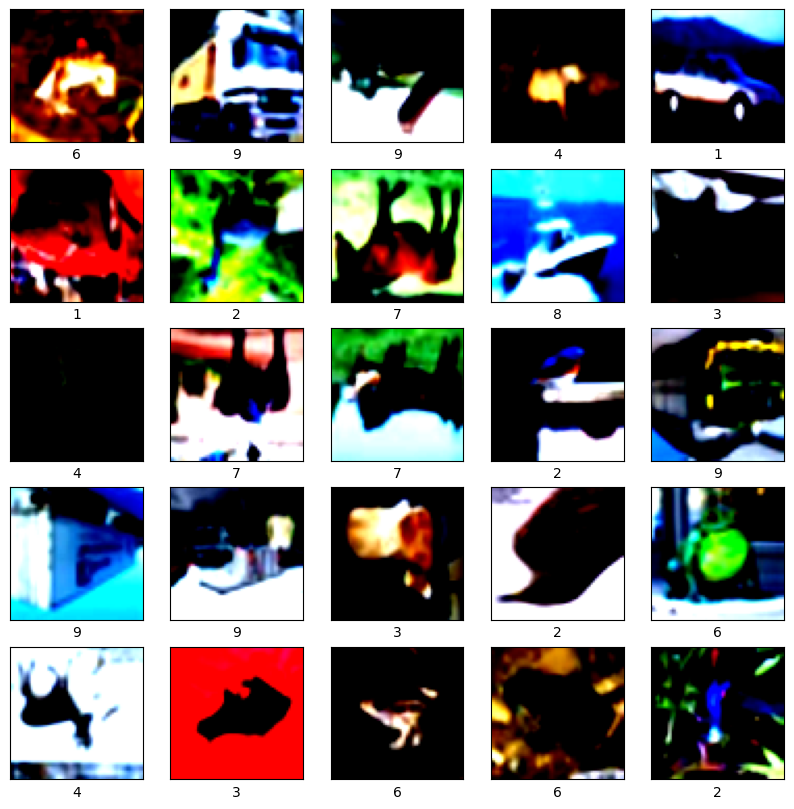

In [11]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 10))

# Iterate over the first 25 samples in the training dataset
for i in range(25):
    # Create subplots in a 5x5 grid
    plt.subplot(5, 5, i + 1)

    # Remove ticks and gridlines
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image (permute is used to change the order of dimensions)
    plt.imshow(data_train[i][0].permute(1, 2, 0).numpy(), cmap=plt.cm.binary)

    # Add the label as xlabel
    plt.xlabel(data_train[i][1])

# Show the plot
plt.show()

In [12]:
def calculate_num_workers():
    # Calculate the number of CPU cores
    num_cpu_cores = os.cpu_count()

    # Set a safe maximum multiplier value (e.g., 0.5) to avoid using all available resources
    max_multiplier = 0.5

    # Calculate the number of workers based on the available resources
    multiplier = min(sum(psutil.cpu_percent(interval=1, percpu=True)) / 100.0, max_multiplier)

    # Ensure that num_workers is at least 1
    num_workers = max(1, int(num_cpu_cores * multiplier))

    return num_workers

In [13]:
# Define train dataloader
train_dataloader = DataLoader(
    data_train,   # Training dataset
    batch_size=BATCH_SIZE,   # Batch size for training
    sampler=RandomSampler(data_train),   # Random sampler for shuffling data
    pin_memory=True,   # Pin memory for faster data transfer to GPU
    num_workers=calculate_num_workers()   # Number of workers for data loading
)

# Define test dataloader
test_dataloader = DataLoader(
    data_test,   # Test dataset
    batch_size=BATCH_SIZE,   # Batch size for testing
    sampler=SequentialSampler(data_test),   # Sequential sampler for sequential testing
    pin_memory=True,   # Pin memory for faster data transfer to GPU
    num_workers=calculate_num_workers()   # Number of workers for data loading
)

In [14]:
class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super().__init__()
        self.module = self.clone_model(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(self.device)

    def clone_model(self, model):
        # Clone the model using deepcopy to ensure a complete copy
        return deepcopy(model)

    def _update(self, model, update_fn):
        with torch.set_grad_enabled(False):
            filtered_state_dict_model = {name: param for name, param in model.state_dict().items() if 'total_ops' not in name and 'total_params' not in name}
            # Update the EMA model's parameters using the decay factor
            for ema_v, model_v in zip(self.module.state_dict().values(), filtered_state_dict_model.values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1 - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)

    def forward(self, *args, **kwargs):
        return self.module(*args, **kwargs)

In [71]:
# Assign device to CUDA (GPU) if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
# Instantiate the ResNet-18 model with pretrained weights
model = torchvision.models.resnet18(pretrained=True)

# Freeze all the parameters in the model
# for param in model.parameters():
#     param.requires_grad = False

# Get the number of input features for the fully connected layer
num_features = model.fc.in_features

# Replace the fully connected layer with a new linear layer for 10 classes
model.fc = nn.Linear(num_features, 10)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)
# model_ema = ModelEMA(model, decay=0.999, device=device)
# model_ema = torch.compile(model=model_ema, backend="inductor", mode="max-autotune")

# model = torch.compile(model=model, backend="inductor", mode="max-autotune")

# Display a summary of the model architecture
# summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE)

In [17]:
class LabelSmoothedCrossEntropy(nn.Module):
    def __init__(self, num_classes, smoothing):
        super(LabelSmoothedCrossEntropy, self).__init__()
        self.num_classes = num_classes  # Number of classes
        self.smoothing = smoothing  # Smoothing factor
        self.confidence = 1.0 - smoothing  # Confidence in true labels

    def forward(self, input_logits, target):

        # Compute log probabilities using log softmax
        log_probs = F.log_softmax(input_logits, dim=-1)

        # Create a tensor to store losses for each sample
        loss = torch.zeros(target.size(0), device=input_logits.device)

        # Compute loss for each sample individually
        for i in range(target.size(0)):
            true_dist = torch.zeros_like(log_probs[i:i+1])  # Select log_probs for the current sample

            # Fill true_dist with the smoothing factor divided by (num_classes - 1)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))

            # Scatter true labels with confidence in true_dist
            true_dist.scatter_(1, target[i:i+1].data.unsqueeze(1), self.confidence)

            # Compute the loss as the negative sum of true_dist times log_probs
            loss[i] = -torch.sum(true_dist * log_probs[i:i+1])


        return loss

In [18]:
# Initialize loss
# criterion = nn.CrossEntropyLoss()

# Using LabelSmoothedCrossEntropy instead of nn.CrossEntropyLoss
criterion = LabelSmoothedCrossEntropy(num_classes=N_CLASSES, smoothing=LABEL_SMOOTHING)

#### Adam w/ Weight Decay

In [19]:
def get_optimizer_grouped_parameters():
    """
    Generate grouped parameters for the optimizer with layerwise learning rate decay.

    Returns:
        list: A list of dictionaries containing grouped parameters for the optimizer.
    """
    no_decay = ['bias', 'BatchNorm2d.weight', 'BatchNorm2d.bias']

    # Initialize list to store optimizer grouped parameters
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if "fc" in n],  # Parameters of the final fully connected layers
            "weight_decay": 0.0,  # No weight decay for these parameters
            "lr": HEAD_LR,  # Learning rate for the head
        },
    ]

    # Get ResNet layers in reverse order
    layers = [model.layer1, model.layer2, model.layer3, model.layer4]
    layers.reverse()

    lr = BASE_LR  # Initialize learning rate for layers
    for layer in layers:
        lr *= LR_DECAY_FACTOR  # Update learning rate with decay factor
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay) and not "fc" in n],  # Parameters with weight decay
                "weight_decay": WEIGHT_DECAY,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay) and not "fc" in n],  # Parameters without weight decay
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [20]:
# Initialize optimizer
# optimizer = optim.Adam(model.parameters(), lr=LR)

# Using AdamW optimizer instead of Adam
optimizer = optim.AdamW(get_optimizer_grouped_parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

#### Cosine Annealing With Warmup

In [21]:
# Define a function to calculate the learning rate lambda
def get_lr_lambda(initial_lr, warmup_steps, total_steps):
    def lr_lambda(current_step):
        # Linear warmup phase
        if current_step < warmup_steps:
            return initial_lr + (1.0 - initial_lr) * float(current_step) / float(max(1, warmup_steps))
        # Cosine annealing phase
        else:
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * (current_step - warmup_steps) / float(total_steps - warmup_steps))))
    return lr_lambda

In [22]:
# Calculate the length of the dataloader
len_dataloader = len(train_dataloader)

# Calculate the number of update steps per epoch
num_update_steps_per_epoch = max(len_dataloader // ACCUMULATION_STEPS, 1)

# Calculate the total number of examples in the dataset
num_examples = len(train_dataloader.dataset)

# Calculate the maximum number of steps (epochs * update steps per epoch)
max_steps = math.ceil(EPOCHS * num_update_steps_per_epoch)

# Calculate the number of warmup steps
num_warmup_steps = math.ceil(max_steps * WARMUP_PROPORTION)

# Get the learning rate lambda function
lr_lambda = get_lr_lambda(BASE_LR, num_warmup_steps, max_steps)

# Create a scheduler with LambdaLR using the learning rate lambda function
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

#### Adaptive Gradient Clipping

In [23]:
def unitwise_norm(x, norm_type=2.0):
    # Calculate the norm of the tensor x
    # If x is 1D or lower, return the norm directly
    if x.ndim <= 1:
        return x.norm(norm_type)
    # If x is higher-dimensional, calculate the norm along all dimensions except the batch dimension
    else:
        return x.norm(norm_type, dim=tuple(range(1, x.ndim)), keepdim=True)


def adaptive_clip_grad(parameters, clip_factor=0.01, eps=1e-3, norm_type=2.0):
    # If parameters is a single tensor, convert it to a list
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    # Iterate over the parameters
    for p in parameters:
        # If the gradient of the parameter is None, skip to the next parameter
        if p.grad is None:
            continue
        # Detach the parameter and its gradient
        p_data = p.detach()
        g_data = p.grad.detach()
        # Calculate the maximum allowed gradient norm
        max_norm = unitwise_norm(p_data, norm_type=norm_type).clamp_(min=eps).mul_(clip_factor)
        # Calculate the norm of the gradient
        grad_norm = unitwise_norm(g_data, norm_type=norm_type)
        # Clip the gradient if its norm exceeds the maximum allowed norm
        clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6))
        # Replace the gradient with the clipped gradient where necessary
        new_grads = torch.where(grad_norm < max_norm, g_data, clipped_grad)
        # Update the gradient of the parameter
        p.grad.detach().copy_(new_grads)

#### Logging Model Parameters

In [24]:
def calculate_flops(input_size):
    # Create a random input tensor with the specified input size
    input_tensor = torch.randn(*input_size).to(device)
    # Profile the model to calculate FLOPs and parameters
    flops, params = profile(model, inputs=(input_tensor,))
    return flops

def calculate_disk_size():
    # Calculate the size of the model on disk in bytes
    disk_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    # Convert bytes to megabytes
    disk_size_mb = disk_size_bytes / (1024 * 1024)
    return disk_size_mb

def get_model_metrics():
    # Calculate the total number of parameters in the model
    num_params = sum(p.numel() for p in model.parameters())
    # Calculate the number of trainable parameters in the model
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Set an example input size (adjust based on your actual input size)
    input_size = tuple(next(iter(train_dataloader))[0][0].unsqueeze(0).shape)

    # Calculate the FLOPs of the model
    flops = calculate_flops(input_size)
    # Calculate the disk size of the model
    disk_size = calculate_disk_size()

    # Return model metrics as a dictionary
    return {
        "num_params": num_params,
        "num_trainable_params": num_trainable_params,
        "flops": flops,
        "disk_size": disk_size
    }

#### Logging GPU Usage

In [25]:
def get_gpu_usage():
    try:
        # Run the nvidia-smi command to get GPU utilization information
        result = subprocess.run(["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,nounits,noheader"], stdout=subprocess.PIPE, text=True)

        # Extract the GPU usage percentage from the command output
        gpu_usage = int(result.stdout.strip())

        # Return the GPU usage percentage
        return gpu_usage
    except Exception as e:
        # Print an error message if an exception occurs
        print(f"Error getting GPU usage: {e}")
        return None

#### Train

##### Gradient Penalty
Its primary purpose is to encourage smoothness in the learned representations of the model by penalizing sharp changes or oscillations in the model's gradients.

##### Gradient Accumulation
Gradient accumulation adds gradients over an effective batch of size `batch_per_iter * iters_to_accumulate` (`* num_procs` if distributed). The scale should be calibrated for the effective batch, which means inf/NaN checking, step skipping if inf/NaN grads are found, and scale updates should occur at effective-batch granularity. Also, grads should remain scaled, and the scale factor should remain constant, while grads for a given effective batch are accumulated. If grads are unscaled (or the scale factor changes) before accumulation is complete, the next backward pass will add scaled grads to unscaled grads (or grads scaled by a different factor) after which it’s impossible to recover the accumulated unscaled grads `step` must apply.

##### Automatic Mixed Precision Training
Automatic Mixed Precision (AMP) training is a technique used in deep learning to accelerate training by using a combination of lower-precision and higher-precision numerical representations. The primary idea behind AMP is to use lower-precision data types (such as float16) for some parts of the model computation, while maintaining higher precision (such as float32) for critical numerical stability aspects.

In [26]:
def train(epoch):
    # Set the model to training mode
    model.train()
    total_loss = 0.0

    # Create a GradScaler once at the beginning of training.
    scaler = torch.cuda.amp.GradScaler()

    # Reset gradients
    optimizer.zero_grad()

    # Iterate over batches in the training dataloader
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch}/Training", unit="batch") as pbar:
        for i, (images, labels) in enumerate(train_dataloader):
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Perform forward pass with autocasting
            with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                output = model(images)
                loss = criterion(output, labels)


            # Perform OHEM
            if epoch >= EPOCHS * OHEM_THRESHOLD:
                num_hard_examples = int(len(images) * 0.5)
                _, topk_indices = loss.topk(num_hard_examples)
                hard_inputs = images[topk_indices]
                hard_targets = labels[topk_indices]

                # Perform forward pass with autocasting
                with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                    output = model(hard_inputs)
                    loss = criterion(output, hard_targets)

            loss = loss.mean()

            # # Scales the loss for autograd.grad's backward pass, producing scaled_grad_params
            # scaled_grad_params = torch.autograd.grad(outputs=scaler.scale(loss), inputs=model.parameters(), create_graph=True)

            # # Creates unscaled grad_params before computing the penalty. scaled_grad_params are
            # # not owned by any optimizer, so ordinary division is used instead of scaler.unscale_:
            # inv_scale = 1. / scaler.get_scale()
            # grad_params = [p * inv_scale for p in scaled_grad_params]

            # # Computes the penalty term and adds it to the loss
            # with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
            #     grad_norm = 0
            #     for grad in grad_params:
            #         grad_norm += grad.pow(2).sum()
            #     grad_norm = grad_norm.sqrt()
            #     loss = loss + grad_norm

            # Scale the loss by accumulation steps
            if ACCUMULATION_STEPS > 1:
                with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                    loss = loss / ACCUMULATION_STEPS

            # Perform backward pass with scaling
            scaler.scale(loss).backward()

            # If the number of accumulated steps reached, update the model parameters
            if (i + 1) % ACCUMULATION_STEPS == 0:
                # Unscales gradients
                scaler.unscale_(optimizer)

                #  Applies clipping
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                adaptive_clip_grad(model.parameters())

                # Perform optimizer step with scaled gradients
                scaler.step(optimizer)

                # Log learning rate and update scheduler
                for i, param_group in enumerate(optimizer.param_groups):
                    mlflow.log_metric(f"lr_group{i}", param_group["lr"])
                scheduler.step()

                # Apply ema
                # if model_ema is not None:
                #   model_ema.update(model)

                # Update scaler for next iteration
                scaler.update()

                # Reset gradients after optimizer step
                for param in model.parameters():
                    param.grad = None

            # Update total loss
            total_loss += loss.item()

            # Update progress bar
            pbar.update(1)

            # Initialize a string to store learning rates
            lr_string = ""

            # Iterate over parameter groups in optimizer
            for i_p, param_group in enumerate(optimizer.param_groups):
                # Append the learning rate to the string
                lr_string += f"{param_group['lr']:.5f}"

                # Add a comma if it's not the last parameter group
                if i_p < len(optimizer.param_groups) - 1:
                    lr_string += ", "

            # Set the learning rate string as the value for the 'lr' key in pbar's postfix dictionary
            pbar.set_postfix(loss=total_loss / (i+1), lr=lr_string)

    # Calculate average loss
    avg_loss = total_loss / len(train_dataloader.dataset)

    # Log average training loss
    mlflow.log_metric("train_loss", avg_loss)

    # Print epoch-wise metrics
    print(f"[Train][Epoch {epoch}] Average Loss: {avg_loss:.5f}, Updated Learning Rate: {optimizer.param_groups[0]['lr']}")

#### Eval

In [27]:
class BestLossTracker:
    def __init__(self):
        # Initialize the best loss to positive infinity
        self.best_loss = float('inf')

    def update_best_loss(self, avg_loss):
        # Update the best loss if the provided loss is lower than the current best loss
        if avg_loss < self.best_loss:
            self.best_loss = avg_loss
            return True  # Return True to indicate that the best loss has been updated
        return False  # Return False if the best loss remains unchanged

In [28]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        # Initialize parameters for early stopping
        self.patience = patience  # Number of epochs to wait before stopping
        self.delta = delta  # Minimum change in validation loss to be considered as improvement
        self.counter = 0  # Counter to keep track of epochs since last improvement
        self.best_loss = float('inf')  # Initialize the best validation loss to positive infinity
        self.early_stop = False  # Flag to indicate whether to stop early

    def update_best_loss(self, val_loss):
        # Check if the provided validation loss is better than the current best loss
        if val_loss < self.best_loss - self.delta:
            # Update the best loss
            self.best_loss = val_loss
            # Reset the counter as there's improvement
            self.counter = 0
        else:
            # Increment the counter if there's no improvement
            self.counter += 1
            # If the counter exceeds patience, set early_stop flag to True
            if self.counter >= self.patience:
                self.early_stop = True

        # Return True if training should continue (not early stopping), False otherwise
        return not self.early_stop

In [29]:
def test(model, epoch, best_loss_tracker, log_suffix=''):
    # Set the model to evaluation mode
    model.eval()
    total_correct = 0
    total_loss = 0.0

    # Iterate over batches in the test dataloader
    with tqdm(total=len(test_dataloader), desc=f"Epoch {epoch}/Testing", unit="batch") as pbar:
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_dataloader):
                images, labels = images.to(device), labels.to(device)

                # Test-time augmentation
                augmented_predictions = []
                augmented_losses = []
                for _ in range(N_TTA):
                    augmented_images = tta_transform(images)
                    augmented_output = model(augmented_images)
                    augmented_loss = criterion(augmented_output, labels)
                    augmented_loss = augmented_loss.mean()
                    augmented_losses.append(augmented_loss.item())
                    augmented_predictions.append(augmented_output.detach().cpu().numpy())

                # Take the average loss over augmentations
                total_loss += sum(augmented_losses) / len(augmented_losses)

                # Take the average of predictions across augmentations
                final_predictions = torch.tensor(np.array(augmented_predictions), dtype=torch.float32).mean(dim=0)
                pred = final_predictions.detach().max(1)[1].to(device)
                total_correct += pred.eq(labels.view_as(pred)).sum()

                # Update progress bar
                pbar.update(1)

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_dataloader.dataset)
    accuracy = total_correct / len(test_dataloader.dataset)

    # Log validation metrics
    mlflow.log_metric(f"val_loss {log_suffix}", avg_loss)
    mlflow.log_metric(f"val_accuracy {log_suffix}", accuracy)

    # Update best loss tracker and save checkpoint if necessary
    if best_loss_tracker.update_best_loss(avg_loss) and "ema" not in log_suffix.lower():
        checkpoint_name = f"checkpoint_best_epoch_{epoch}.pth"
        checkpoint_path = str(SAVE_DIR / "checkpoints" / checkpoint_name)
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[Test][Epoch {epoch}] New best model found! Saving checkpoint. Loss: {avg_loss:.5f}, Accuracy: {accuracy:.3f}")
    else:
        print(f"{log_suffix}[Test][Epoch {epoch}] Loss: {avg_loss:.5f}, Accuracy: {accuracy:.3f}")

    return avg_loss

#### Run

In [30]:
def progressive_resize(epoch):
    """
    Adjusts the size of images progressively based on the epoch.

    Args:
    - epoch (int): Current epoch number.
    - max_size (int): Maximum desired size.

    Returns:
    None
    """
    global max_size

    if (epoch + 1) % 2 == 0 and max_size < 224:
        max_size += 64  # Increase size by 64
        max_size = min(max_size, 224) # Clamp to 224
        print(f"Max size increased to {max_size}")

    # Resize images based on the current max_size
    if max_size == 64:
        train_transforms.transforms[0] = transforms.Resize(64)
        valid_transforms.transforms[0] = transforms.Resize(64)
        print("Resizing images to 64x64")
    elif max_size == 128:
        train_transforms.transforms[0] = transforms.Resize(128)
        valid_transforms.transforms[0] = transforms.Resize(128)
        print("Resizing images to 128x128")
    elif max_size == 192:
        train_transforms.transforms[0] = transforms.Resize(192)
        valid_transforms.transforms[0] = transforms.Resize(192)
        print("Resizing images to 192x192")
    elif max_size == 224:
        train_transforms.transforms[0] = transforms.Resize(224)
        valid_transforms.transforms[0] = transforms.Resize(224)
        print("Resizing images to 224x224")

In [31]:
def run():

    # Start MLflow run
    with mlflow.start_run(run_name="Transfer Learning"):
        # Log Torch and MLflow versions
        mlflow.log_param("torch_version", torch.__version__)
        mlflow.log_param("mlflow_version", mlflow.__version__)

        # Log hyperparameters
        hyper_params = {
            "accumulation_steps": ACCUMULATION_STEPS,
            "batch_size": BATCH_SIZE,
            "dropout":DROPOUT_PROB,
            "epochs": EPOCHS,
            "batchnorm": USE_BATCHNORM,
            "label_smoothing": LABEL_SMOOTHING,
            "base_lr": BASE_LR,
            "head_lr":HEAD_LR,
            "lr_decay":LR_DECAY_FACTOR,
            "warmup_proortion": WARMUP_PROPORTION,
            "weight_decay": WEIGHT_DECAY
        }
        mlflow.log_params(hyper_params)

        # Set tags
        mlflow.set_tags({"model": "lenet", "dataset": "mnist"})

        # Log the model architecture
        mlflow.pytorch.log_model(model, "model")

         # Log start time
        mlflow.log_param("start_time", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

        # Log model metrics
        model_metrics = get_model_metrics()
        mlflow.log_param("num_params", model_metrics['num_params'])
        mlflow.log_param("num_trainable_params", model_metrics['num_trainable_params'])
        mlflow.log_param("flops", model_metrics['flops'])
        mlflow.log_param("disk_size", model_metrics['disk_size'])

        # Initialize best loss tracker and early stopping
        best_loss_tracker = BestLossTracker()
        early_stopping = EarlyStopping(patience=3, delta=1e-6)

        # Start training and testing loop
        start_time = time.time()
        for epoch in range(EPOCHS):
            # Progressive Resizing
            progressive_resize(epoch)

            # Training
            train(epoch)

            # Validation
            val_loss = test(model, epoch, best_loss_tracker)

            # EMA Validation
            # ema_val_loss = test(model_ema, epoch, best_loss_tracker, log_suffix='EMA')

            # Log GPU usage if available
            if get_gpu_usage() is not None:
                mlflow.log_metric("gpu", get_gpu_usage(), step=epoch)

            # Check for early stopping
            if not early_stopping.update_best_loss(val_loss):
                print("Early stopping triggered.")
                break

        # Calculate and log training time metrics
        total_time = time.time() - start_time
        avg_epoch_time = total_time / EPOCHS
        avg_batch_time = avg_epoch_time / len(train_dataloader)

        mlflow.log_metric("total_training_time", total_time)
        mlflow.log_metric("average_epoch_time", avg_epoch_time)
        mlflow.log_metric("average_batch_time", avg_batch_time)

        # Log end time
        mlflow.log_param("end_time", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Dump snapshot of the current GPU memory state
# torch.cuda.memory._dump_snapshot("snapshot.pickle")

In [32]:
run()

2024/03/17 20:09:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/03/17 20:09:15 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.17.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.17.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/03/17 20:09:15 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.23+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.23' without t

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Resizing images to 64x64


Epoch 0/Training:   0%|          | 0/196 [00:00<?, ?batch/s]

[Train][Epoch 0] Average Loss: 0.00285, Updated Learning Rate: 0.0


Epoch 0/Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

[Test][Epoch 0] New best model found! Saving checkpoint. Loss: 0.00388, Accuracy: 0.834


## Exporting PyTorch Models

In [73]:
# Load the pre-trained model state dictionary from a saved checkpoint file
model.load_state_dict(torch.load("./artifacts/exp2/checkpoints/checkpoint_best_epoch_0.pth"), strict=False);

# Set the model to evaluation mode
model.eval();

# The model is now loaded with weights from the specified checkpoint file and ready for inference
# Evaluation mode is set to ensure that parameters like dropout are fixed, and the model behaves deterministically during inference.

(SAVE_DIR / 'export').mkdir(parents=True, exist_ok=True)

**PyTorch `torch.save()`**: Serialize the model and save it to disk using the torch.save() function. This method saves the entire model, including the architecture and the trained parameters.

In [37]:
torch.save(model, (SAVE_DIR / 'export' / 'model.pth'))

**State Dict `model.state_dict()`**: Save only the model's parameters (state dictionary) using the model.state_dict() method. This method excludes the model architecture and optimizers' states.

In [38]:
torch.save(model.state_dict(), (SAVE_DIR / 'export' / 'model_state_dict.pth'))

**ONNX**: Export the model to the Open Neural Network Exchange (ONNX) format, which allows interoperability between different deep learning frameworks. Use torch.onnx.export() function.

In [43]:
dummy_input = torch.randn(1, 3, 64, 64).to(device)
torch.onnx.export(model, dummy_input, (SAVE_DIR / 'export' / 'model.onnx'), verbose=True)


**TorchScript**: Convert the PyTorch model to TorchScript, a statically-typed subset of Python that can be executed independently from the Python runtime. Use `torch.jit.script()` or `torch.jit.trace()` functions.

In [44]:
scripted_model = torch.jit.script(model)
scripted_model.save((SAVE_DIR / 'export' / 'scripted_model.pt'))

**TorchScript Module**: Export the entire model as a TorchScript module. This method combines the benefits of TorchScript and `torch.save()` by preserving the model's architecture and parameters.

In [45]:
scripted_module = torch.jit.script(model)
torch.jit.save(scripted_module, (SAVE_DIR / 'export' / 'scripted_module.pt'))

**TensorFlow Lite**: Converting a PyTorch checkpoint to TensorFlow Lite (TFLite) involves several steps. Here's a general outline of the process:

1. **Load PyTorch Model**: Load your PyTorch model from the checkpoint. This model can be either the full model or just the state dictionary containing the parameters.

2. **Convert PyTorch Model to TensorFlow**: Convert the PyTorch model to a TensorFlow model. You can use tools like ONNX to export the PyTorch model to ONNX format and then convert the ONNX model to TensorFlow using ONNX-TF.

3. **Optimize TensorFlow Model**: Optimize the TensorFlow model for inference. This may involve quantization, pruning, or other optimization techniques to reduce the model size and improve performance.

4. **Convert TensorFlow Model to TensorFlow Lite**: Convert the optimized TensorFlow model to TensorFlow Lite format using TensorFlow Lite Converter.

#### PyTorch to ONNX

In [65]:
import tensorflow as tf
import onnx
import onnx_tf
from onnx_tf.backend import prepare

In [80]:
# Step 1: Load PyTorch Model
# Load PyTorch model from checkpoint
model.load_state_dict(torch.load('artifacts/exp2/checkpoints/checkpoint_best_epoch_0.pth'), strict=False)
model.eval();

In [84]:
# Step 2: Convert PyTorch Model to TensorFlow
# Export PyTorch model to ONNX format
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input shape
torch.onnx.export(model, dummy_input, 'model.onnx', opset_version=12, input_names=['input'], output_names=['output'])

#### ONNX to TF

In [85]:
# Load ONNX model
onnx_model = onnx.load('model.onnx')

In [87]:
# Check that the IR is well formed
onnx.checker.check_model(onnx_model)

In [89]:
# Print a Human readable representation of the graph
onnx.helper.printable_graph(onnx_model.graph)

'graph main_graph (\n  %input[FLOAT, 1x3x224x224]\n) initializers (\n  %fc.weight[FLOAT, 10x512]\n  %fc.bias[FLOAT, 10]\n  %onnx::Conv_193[FLOAT, 64x3x7x7]\n  %onnx::Conv_194[FLOAT, 64]\n  %onnx::Conv_196[FLOAT, 64x64x3x3]\n  %onnx::Conv_197[FLOAT, 64]\n  %onnx::Conv_199[FLOAT, 64x64x3x3]\n  %onnx::Conv_200[FLOAT, 64]\n  %onnx::Conv_202[FLOAT, 64x64x3x3]\n  %onnx::Conv_203[FLOAT, 64]\n  %onnx::Conv_205[FLOAT, 64x64x3x3]\n  %onnx::Conv_206[FLOAT, 64]\n  %onnx::Conv_208[FLOAT, 128x64x3x3]\n  %onnx::Conv_209[FLOAT, 128]\n  %onnx::Conv_211[FLOAT, 128x128x3x3]\n  %onnx::Conv_212[FLOAT, 128]\n  %onnx::Conv_214[FLOAT, 128x64x1x1]\n  %onnx::Conv_215[FLOAT, 128]\n  %onnx::Conv_217[FLOAT, 128x128x3x3]\n  %onnx::Conv_218[FLOAT, 128]\n  %onnx::Conv_220[FLOAT, 128x128x3x3]\n  %onnx::Conv_221[FLOAT, 128]\n  %onnx::Conv_223[FLOAT, 256x128x3x3]\n  %onnx::Conv_224[FLOAT, 256]\n  %onnx::Conv_226[FLOAT, 256x256x3x3]\n  %onnx::Conv_227[FLOAT, 256]\n  %onnx::Conv_229[FLOAT, 256x128x1x1]\n  %onnx::Conv_230[

In [92]:
# Convert ONNX model to TensorFlow
tf_rep = prepare(onnx_model)

# Export TF model
tf_model_path = SAVE_DIR / 'export' /'model_tf'
tf_rep.export_graph(tf_model_path)

INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_62_x, add_19_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to /content/artifacts/exp2/export/model_tf/fingerprint.pb


In [95]:
# Inference with TensorFlow
import tensorflow as tf

model = tf.saved_model.load(tf_model_path)
model.trainable = False

input_tensor = tf.random.uniform([1, 3, 224, 224])
out = model(**{'input': input_tensor})

In [96]:
out

{'output': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[19.390163, 16.578392, 17.75736 , 19.460892, 18.28109 , 17.054722,
         17.830421, 16.868128, 17.224869, 16.57028 ]], dtype=float32)>}

#### TF to TFLite

In [94]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(str(tf_model_path))
tflite_model = converter.convert()

# Save the model
tflite_model_path = str(SAVE_DIR / 'export' / 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [97]:
# Inference with TFLite
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="artifacts/exp2/export/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[19.376898 16.607351 17.799345 19.49065  18.287277 17.021133 17.898228
  16.789593 17.181904 16.567654]]
